# Implementation of the Phase Estimation Algorithm
Goal: To find an approximate solution for $\varphi$ with $U|u\rangle = e^{2\pi\iota\varphi}|u\rangle$.
<br />
Given: An oracle that can perform the operation $U^{2^j}|u\rangle$ for any $j \geq 0, j \in \Z$

In [276]:
from qiskit import Aer, assemble, QuantumCircuit
sim = Aer.get_backend('aer_simulator')

from math import pi, sin, cos, ceil, log2
from qiskit.visualization import plot_histogram

In [277]:
def oracle1(ckt: QuantumCircuit, j: int, control: int, target: int, alpha=1/8):
    ckt.cp(2*pi*alpha*(2**j), control, target)

#def oracle2(ckt: QuantumCircuit, j: int, control: int, target: int):
    

In [278]:
def R_k(ckt: QuantumCircuit, index: int, k: int, inverse=False):
    ckt.cp((-1 if inverse else 1)*pi/(2**k), index, index + k)

# computes the fourier/inverse fourier transform of a set of sz qubits. Clearly the algorithm employs O(sz^2) gates.
def ft(ckt: QuantumCircuit, sz: int, inverse=False, start=0):
    """sz: number of qubits representing the state to take the fourier transform of. The said qubits start from index start and are assumed to be contiguous."""
    for i in range(sz): 
        ckt.h(start + i)
        for j in range(i+1, sz):
            R_k(ckt, start + i, j-i, inverse)
        ckt.barrier()
    for i in range(sz//2):
        ckt.swap(start + i, start + sz-1-i)
    ckt.barrier()
    return ckt

In [279]:
def estimate_phase(ckt: QuantumCircuit, sz: int, oracle):
    for i in range(sz): 
        ckt.h(i)
    ckt.barrier()
    for i in range(sz): 
        oracle(ckt, i, sz-1-i, sz, 1/3)
    ckt.barrier()
    ft(ckt, sz, inverse=True, start=0)
    for i in range(sz): 
        ckt.measure(i, i)

5


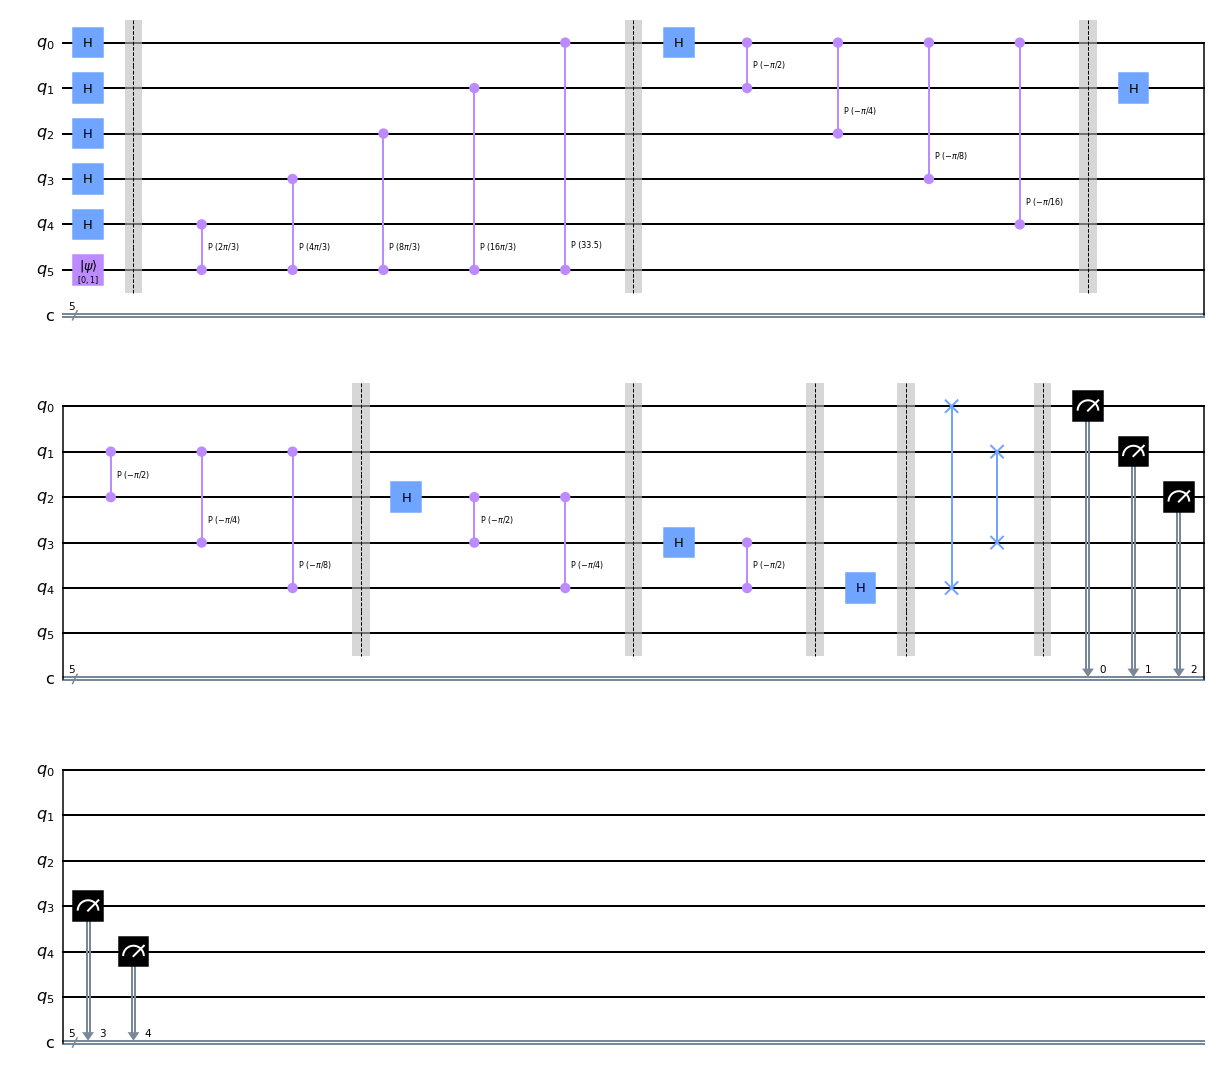

In [280]:
precision = 2
epsilon = 0.1
sz = precision + ceil(log2(2 + 1/(2*epsilon))) 
print(sz)

n = 1 # number of qubits in the second register.
ckt = QuantumCircuit(sz + n, sz)
ckt.initialize([0, 1], sz)
estimate_phase(ckt, sz, oracle=oracle1)
ckt.draw("mpl")

0.949676513671875


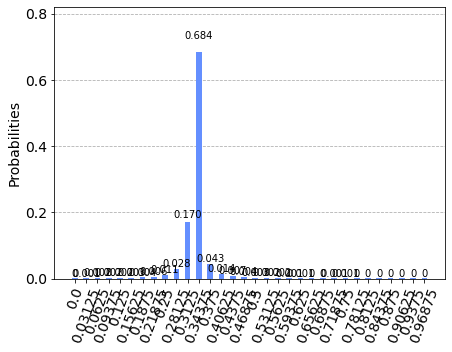

In [281]:
shots = 65536
counts = sim.run(ckt, shots=shots).result().get_counts()
#print(counts)
answers = {}
phi_values = {}
for key in counts:
    phi = int(key[::-1], 2)/(2**sz)
    theta = 2*pi*phi
    
    eigenval = complex(0, 0)
    if (abs(cos(theta)) > 1e-15): eigenval += cos(theta)
    if (abs(sin(theta)) > 1e-15): eigenval += 1j*sin(theta)

    answers[eigenval] = counts[key]/shots # normalize counts.
    phi_values[phi] = counts[key]/shots

prob_of_success = 0
for phi in phi_values:
    if abs(phi - 1/3) <= epsilon: prob_of_success += phi_values[phi]
print(prob_of_success) # somehow prob_of_success < 1-epsilon for smaller epsilon, why?

#print("All phases:", phi_values, sep="\n")
#print("eigenvalues:", answers)
plot_histogram(phi_values)